In [1]:
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
import anndata as ad
import joblib
import palantir
import matplotlib.pyplot as plt
sc.settings._vector_friendly=True

In [19]:
import rnanorm

In [76]:
sc.settings.figdir="../result/11.17_pseudo_model_selection/"

In [ ]:
adata=sc.read("../../temp_data/11.19_longbone_diabetes.h5ad")

In [6]:
rf_gene=pd.read_csv("../../important_processed_data/10.29_rf_importance_gene.csv")

In [7]:
gene=rf_gene["gene"][rf_gene["importance"]>0.000008]


In [ ]:
adata.layers["counts"]=adata.X

In [ ]:
newadata=sc.AnnData(
        X=adata.X,
        var=adata.var_names.values,
        obs=adata.obs,
    )

In [ ]:
newadata.layers["counts"]=adata.layers["counts"]

In [ ]:
newadata.var_names=adata.var_names

In [ ]:

def formOsteoAdata(adata,missing_threshold=500,variableFeature="Default"):
    
    if isinstance(variableFeature,str):
        if variableFeature=="Default":
            variableFeature=pd.read_csv(highVarGeneFile,index_col=0)["0"].values
    if(len(variableFeature)-adata.var_names.isin(variableFeature).sum()>missing_threshold):
        raise ValueError("Too many missing gene! Please check data!")
        
    print("Total number of genes needed for mapping:",len(variableFeature))
    print(
        "Number of genes found in query dataset:",
        adata.var_names.isin(variableFeature).sum(),
    )
    missing_genes = [
        gene_id
        for gene_id in variableFeature
        if gene_id not in adata.var_names
    ]
    missing_gene_adata = sc.AnnData(
        X=csr_matrix(np.zeros(shape=(adata.n_obs, len(missing_genes))), dtype="float32"),
        obs=adata.obs.iloc[:, :1],
        var=missing_genes,
    )
    missing_gene_adata.var_names=missing_genes
    missing_gene_adata.layers["counts"] = missing_gene_adata.X
    if "PCs" in adata.varm.keys():
        del adata.varm["PCs"]
        
    adata_merged = sc.concat(
        [adata, missing_gene_adata],
        axis=1,
        join="outer",
        index_unique=None,
        merge="unique",
    )
    adata_merged = adata_merged[
        :, variableFeature
    ].copy()
    return(adata_merged)


In [ ]:
newadata=formOsteoAdata(newadata,missing_threshold=500,variableFeature=gene)

In [2]:
model = joblib.load('../processed_data/11.16_pseudo_predict_model/11.18_lightGBM_pred.pkl')

In [ ]:
dataDf=newadata.layers["counts"].toarray()

In [ ]:
dpt=model.predict(dataDf)

In [ ]:
adata.obs["pseudotime"]=dpt

In [ ]:
np.array(adata.obsm["UMAP"])

In [ ]:
adata.obsm["X_umap"]=np.array(adata.obsm["UMAP"])

In [ ]:
sc.pl.umap(adata,color="pseudotime")

In [ ]:
adata.obsm["X_pca"]=np.array(adata.obsm['HARMONY'])

In [ ]:
adata.obsm["X_pca"]

In [ ]:
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [35]:
adata.obs["ident"]

AAACCCACATACCGTA-1_1    Lepr+ BMSC
AAACCCAGTAATCAAG-1_1    Lepr+ BMSC
AAACCCAGTATGTCCA-1_1    Lepr+ BMSC
AAACCCAGTATTGACC-1_1    Lepr+ BMSC
AAACCCATCAGGTAAA-1_1    Lepr+ BMSC
                           ...    
TTTGTTGGTAACACGG-1_6    Lepr+ BMSC
TTTGTTGGTCCATACA-1_6    Lepr+ BMSC
TTTGTTGGTTCTCCCA-1_6    Lepr+ BMSC
TTTGTTGTCGCGCCAA-1_6        Pre-ob
TTTGTTGTCTCCTGTG-1_6    Lepr+ BMSC
Name: ident, Length: 28606, dtype: category
Categories (3, object): ['Lepr+ BMSC', 'Pre-ob', 'Ob']

In [37]:
startCell = pd.Series(
    ["Lepr"],
    index=[
           adata.obs_names[np.flatnonzero(adata.obs['ident']  == 'Lepr+ BMSC')[0]]]
)

In [48]:
endCell = pd.Series(
    ["bone"],
    index=[adata.obs_names[np.flatnonzero(adata.obs['ident']  == 'Ob')[0]]]
)

(<Figure size 400x400 with 1 Axes>, <Axes: >)

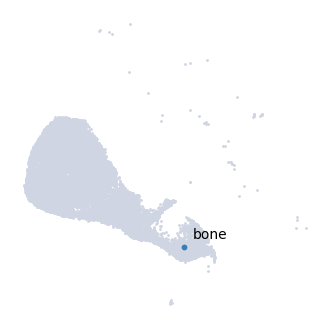

In [49]:
palantir.plot.highlight_cells_on_umap(adata, endCell)

/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


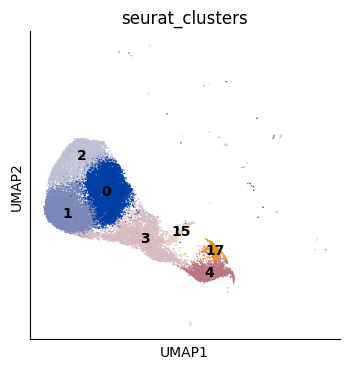

In [59]:
sc.pl.umap(adata,color="seurat_clusters",legend_loc="on data")

In [60]:
adata=adata[adata.obs["seurat_clusters"]!="15"]

/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [63]:
pr_res = palantir.core.run_palantir(
    adata, startCell.index[0], num_waypoints=500,terminal_states=endCell
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.07178204456965129 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 1.6529844999313354 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/palantir/core.py:179: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs[pseudo_time_key] = pseudotime


In [72]:
adata.obs["palantir_dpt"]=pr_res.pseudotime

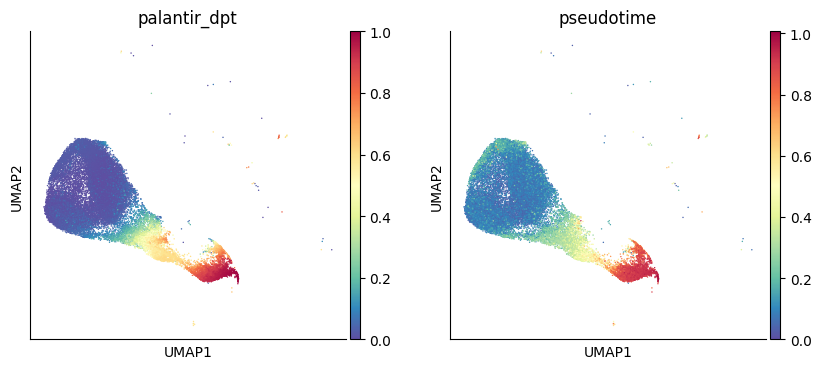

In [81]:
sc.pl.umap(adata,color=["palantir_dpt","pseudotime"],vmin=0,save="_pedict_longbone")

In [66]:
from scipy.stats import rankdata
rnk1=rankdata(adata.obs["palantir"])
rnk2=rankdata(adata.obs["pseudotime"])

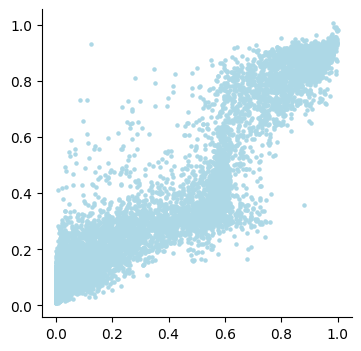

In [78]:
plt.scatter(adata.obs["palantir_dpt"], adata.obs["pseudotime"],s=5, marker='o',color='lightblue',rasterized=True)
plt.savefig("../result/11.17_pseudo_model_selection/pseudo_prediction_scatter.pdf")

In [26]:
geneCount2=pd.read_csv("../processed_data/11.16_pseudo_predict_model/11.19_predict_count_com_GSE54461.csv",index_col=0)

In [32]:
geneCount2.index=geneCount["geneid"]

In [33]:
missing_values =  set(gene)-set(geneCount["geneid"])
for missing_value in missing_values:
    geneCount2.loc[missing_value] = 0 

In [34]:
geneCount2=geneCount2.loc[gene]

In [36]:
dptbulk2=model.predict(geneCount2.T)

In [52]:
# Original vector
original_vector = [2, 4,6,8,10,12,14,16,18]

# Replicate each element three times
replicated_vector = np.repeat(original_vector, 3)

In [53]:
boxData=pd.DataFrame({"dpt":dptbulk2,"time":replicated_vector})

/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


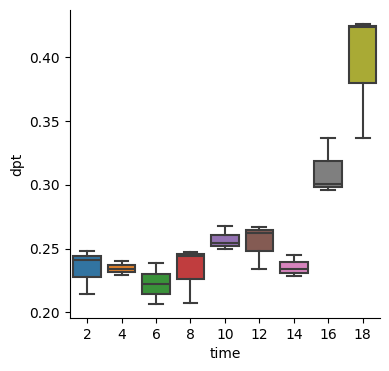

In [56]:
import seaborn as sns
sns.boxplot(x='time', y='dpt', data=boxData)
plt.savefig("../result/11.17_pseudo_model_selection/pred_bulk.pdf")

In [28]:
# bulk rna predict
geneCount=pd.read_csv("../processed_data/11.16_pseudo_predict_model/11.19_predict_count_GSE54461.csv",index_col=0)
geneCount["geneid"]

1              Gnai3
2               Pbsn
3              Cdc45
4                H19
5              Scml2
            ...     
37987            NaN
37988            NaN
37989            NaN
37990    Vmn1r-ps147
37991        Methig1
Name: geneid, Length: 37991, dtype: object

In [4]:
geneCount.index=geneCount["geneid"]

In [8]:
sum(geneCount["geneid"].isin(gene))

2047

In [9]:
missing_values =  set(gene)-set(geneCount["geneid"])
for missing_value in missing_values:
    geneCount.loc[missing_value] = 0 

In [10]:
geneCount=geneCount.loc[gene]

In [11]:
geneCount=geneCount.iloc[:,0:18]

In [18]:
geneCount.loc["Bglap2"]

2        1.42
2.1      0.00
2.2      3.00
4        0.00
4.1      5.60
4.2      4.00
6        3.00
6.1      1.62
6.2      7.00
8        5.00
8.1      4.00
8.2      5.00
10       2.00
10.1     4.00
10.2     9.00
12      30.68
12.1    28.28
12.2    22.96
Name: Bglap2, dtype: float64

In [14]:
dptbulk=model.predict(geneCount.T)

In [15]:
dptbulk

array([0.3161452 , 0.3257866 , 0.32188029, 0.3926801 , 0.43684302,
       0.36432865, 0.34835603, 0.27439785, 0.34482899, 0.40166034,
       0.31808185, 0.41544607, 0.32647078, 0.31377372, 0.3507888 ,
       0.45843997, 0.46511121, 0.46110452])